# Lensing Bayesian Inference Workflow

This notebook demonstrates a complete Bayesian inference workflow for weak gravitational lensing:

1. **Gradient Analysis**: Compute and visualize gradients of the forward model w.r.t. cosmological parameters
2. **Synthetic Observations**: Generate fiducial model predictions (convergence maps and lightcone)
3. **MCMC Sampling**: Infer cosmological parameters from observations using NUTS/HMC/MCLMC
4. **Results Analysis**: Plot posteriors and compare inferred vs. true initial conditions

The notebook is structured to allow resuming from the MCMC sampling section without regenerating observations.

## 1. Imports

## Important Notes

**NumPyro Sharding Limitation:**
NumPyro does NOT support distributed sharding with checkpoint resumption. When resuming from a saved state, sharding information is lost. For distributed/sharded workflows, use `backend="blackjax"`.

**Spherical vs Flat Geometry:**
- Spherical geometry uses HEALPix with visibility masking (only visible pixels are sampled)
- Flat geometry uses Cartesian coordinates (all pixels within field)
- Use `reconstruct_full_kappa()` to convert visible-pixel maps to full HEALPix maps for plotting

In [ ]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from jaxpm.spherical import spherical_visibility_mask
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import (
    compute_box_size_from_redshift,
    compute_max_redshift_from_box_size,
    make_full_field_model,
)   
from fwd_model_tools.plotting import (
    plot_gradient_analysis,
    plot_ic,
    plot_kappa,
    plot_lightcone,
    plot_posterior,
)
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

: 

## 2. Configuration Parameters

Edit these parameters to customize the workflow. These correspond to the argparse arguments in `run_lensing_model.py`.

In [2]:
output_dir = "output_notebook"
box_shape = (16, 16, 16)
box_size = None
max_redshift = 0.5
geometry = "spherical"
observer_position = (0.5, 0.5, 1.0)
num_warmup = 100
num_samples = 10
batch_count = 2
sampler = "MCLMC"  # "NUTS", "HMC", or "MCLMC"
backend = "blackjax"  # "blackjax" recommended for sharded runs (see Important Notes below)
sigma_e = 0.3
magick_seed = 42
pdims = (4, 2)

gradient_offset_omega_c = 0.05
gradient_offset_sigma8 = 0.1

## 3. Setup Functions

In [3]:
def setup_output_dir(output_dir):
    output_dir = Path(output_dir)
    plots_dir = output_dir / "plots"
    samples_dir = output_dir / "samples"
    data_dir = output_dir / "data"

    plots_dir.mkdir(parents=True, exist_ok=True)
    samples_dir.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)

    return output_dir, plots_dir, samples_dir, data_dir


def setup_sharding(pdims=(4, 2)):
    if jax.device_count() > 1:
        from jax.sharding import NamedSharding
        from jax.sharding import PartitionSpec as P

        mesh = jax.make_mesh(pdims, ("x", "y"))
        sharding = NamedSharding(mesh, P("x", "y"))
        print(f"Using sharding with mesh: {pdims}")
    else:
        sharding = None
        print("Single device mode - no sharding")

    return sharding


def create_redshift_distribution(
    cosmo,
    box_size=None,
    observer_position=(0.5, 0.5, 0.5),
    geometry="spherical",
    max_redshift=None,
):
    print("\n" + "=" * 60)
    print("Creating redshift distribution")
    print("=" * 60)

    if box_size is None and max_redshift is None:
        raise ValueError("Either box_size or max_redshift must be provided")

    if box_size is None:
        box_size = compute_box_size_from_redshift(cosmo, max_redshift,
                                                  observer_position)
        print(
            f"Auto-computed box size: {box_size} Mpc/h for max redshift {max_redshift}"
        )
    elif max_redshift is None:
        max_redshift = compute_max_redshift_from_box_size(
            cosmo, box_size, observer_position)
        print(
            f"Auto-computed max redshift: {max_redshift} for box size {box_size} Mpc/h"
        )

    z = jnp.linspace(0, max_redshift, 1000)
    z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
    z_centers = jnp.round(z_centers, 3)
    print(f"z_centers = {z_centers}")

    nz_shear = [
        jc.redshift.kde_nz(
            z,
            norm.pdf(z, loc=z_center, scale=0.12),
            bw=0.01,
            zmax=max_redshift,
            gals_per_arcmin2=g,
        ) for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
    ]
    nbins = len(nz_shear)

    return nz_shear, nbins, max_redshift, box_size


output_dir_path, plots_dir, samples_dir, data_dir = setup_output_dir(output_dir)
sharding = setup_sharding(pdims)
fiducial_cosmology = Planck18()

nz_shear, nbins, max_redshift, box_size = create_redshift_distribution(
    fiducial_cosmology,
    box_size,
    observer_position=observer_position,
    geometry=geometry,
    max_redshift=max_redshift,
)

config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    density_plane_width=100.0,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.24, 0.28),
        "sigma8": dist.Uniform(0.78, 0.82),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=False,
    log_ic=False,
)

print("\nGenerating initial conditions...")
initial_conditions = normal_field(jax.random.key(magick_seed),
                                  config.box_shape,
                                  sharding=sharding)
print("‚úì Initial conditions generated")
jax.debug.visualize_array_sharding(initial_conditions[:, :, 0])

Single device mode - no sharding

Creating redshift distribution
Auto-computed box size: (2635.3309394476964, 2635.3309394476964, 1317.6654697238482) Mpc/h for max redshift 0.5
z_centers = [0.2   0.297 0.393 0.49 ]

Generating initial conditions...
‚úì Initial conditions generated


                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

## 4. Generate Synthetic Observations

Trace the fiducial model to create synthetic convergence maps and lightcone data.

In [4]:
print("\n" + "=" * 60)
print("Generating synthetic observations")
print("=" * 60)

config_with_logging = config._replace(log_lightcone=True, log_ic=True)
full_field_basemodel = full_field_probmodel(config_with_logging)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model to generate observables...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"‚úì Fiducial model traced in {elapsed:.2f}s")

nbins = len(config.nz_shear)
kappa_keys = [f"kappa_{i}" for i in range(nbins)]

# Keep visible-pixel kappas for inference
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

# Prepare full maps only for plotting (spherical geometry)
if config.geometry == "spherical":
    true_kappas_full = reconstruct_full_kappa(
        true_kappas_visible, config.nside, config.observer_position
    )
else:
    true_kappas_full = true_kappas_visible

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,  # Save visible kappas for inference
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)
print(f"‚úì Saved true kappas to {data_dir / 'true_kappas.npz'}")

true_ic = np.asarray(model_trace["ic"]["value"])
np.save(data_dir / "true_ic.npy", true_ic)
print(f"‚úì Saved true IC to {data_dir / 'true_ic.npy'}")

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)
print(f"‚úì Saved true lightcone to {data_dir / 'true_lightcone.npy'}")


Generating synthetic observations
Tracing fiducial model to generate observables...


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


‚úì Fiducial model traced in 7.92s
‚úì Saved true kappas to output_notebook/data/true_kappas.npz
‚úì Saved true IC to output_notebook/data/true_ic.npy
‚úì Saved true lightcone to output_notebook/data/true_lightcone.npy


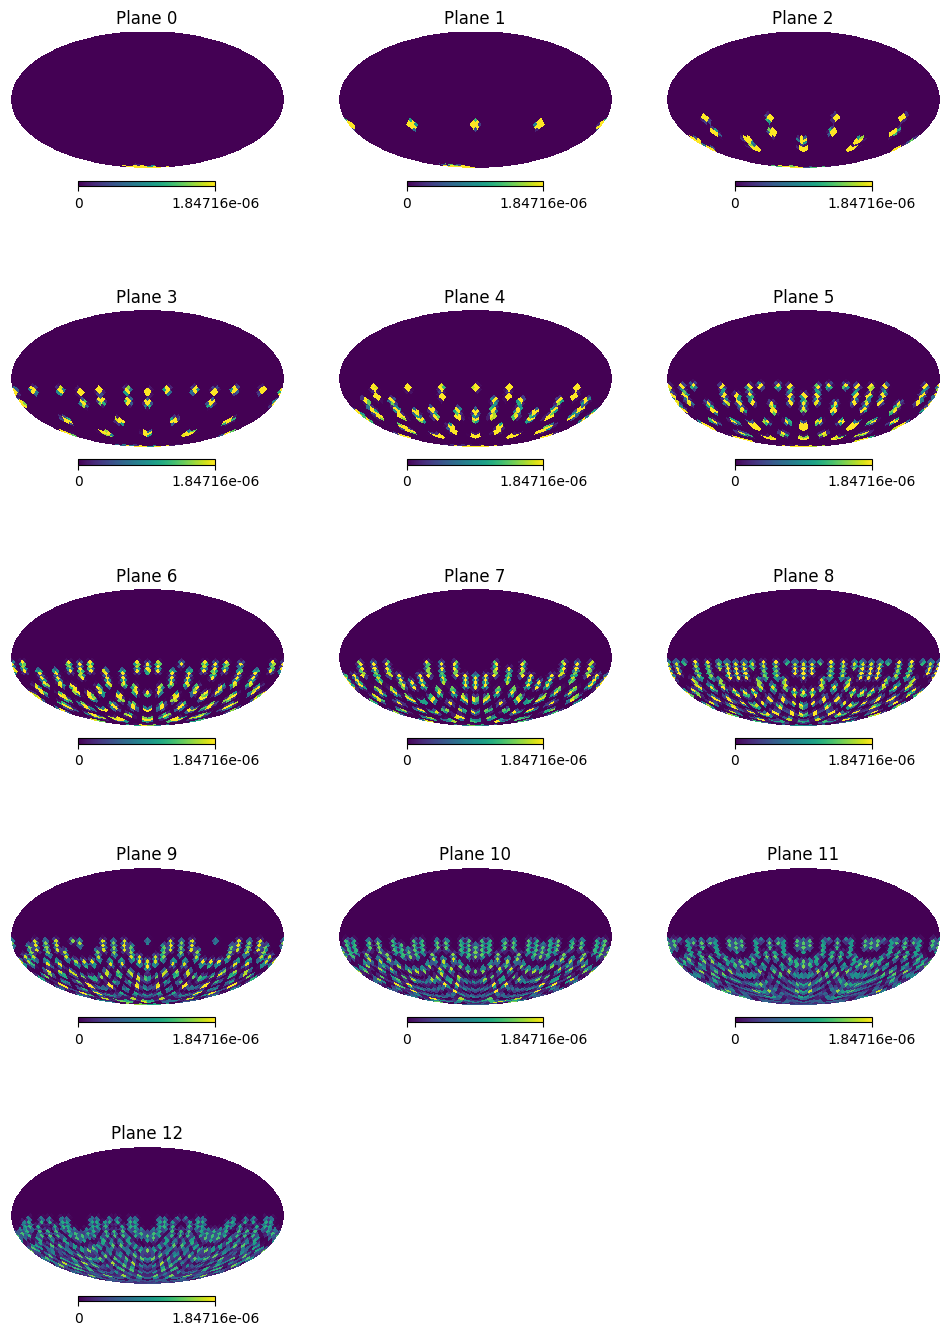

‚úì Plotted lightcone to 


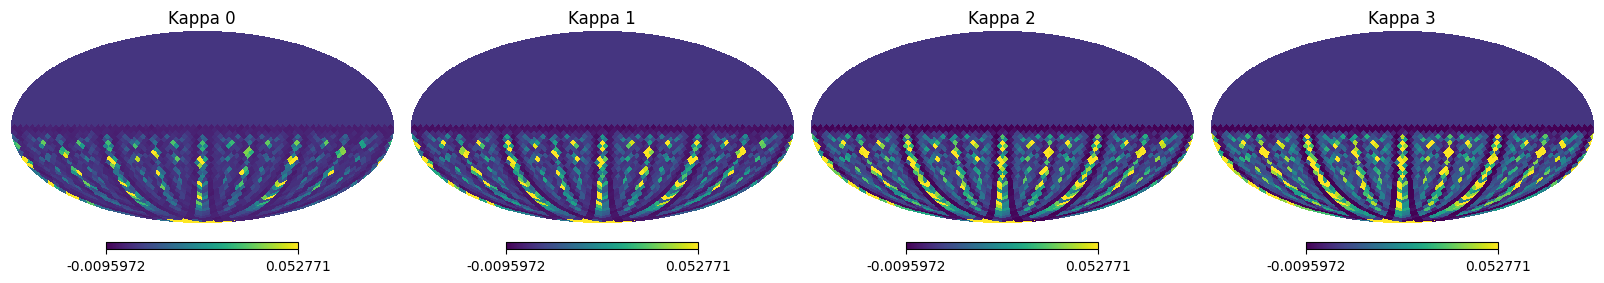

‚úì Plotted kappa maps to 


In [5]:
plot_lightcone(true_lightcone, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print(f"‚úì Plotted lightcone to ")

# Use full maps for plotting
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print(f"‚úì Plotted kappa maps to ")

## 5. Gradient Analysis

Compute gradients of the forward model w.r.t. cosmological parameters using MSE loss relative to fiducial observations.

We evaluate the sensitivity by computing: `loss = mean((kappa_model - kappa_obs)¬≤)` at the fiducial parameters ¬± offsets.
This shows how changes in Omega_c and sigma8 affect the observables around the true values.

In [6]:
print("\n" + "=" * 60)
print("Creating forward model for gradient analysis")
print("=" * 60)
visible_mask = spherical_visibility_mask(config.nside, config.observer_position)
visible_indices, = jnp.where(visible_mask == 1)

forward_model = make_full_field_model(
    field_size=config.field_size,
    field_npix=config.field_npix,
    box_shape=config.box_shape,
    box_size=config.box_size,
    density_plane_width=config.density_plane_width,
    density_plane_npix=config.density_plane_npix,
    density_plane_smoothing=config.density_plane_smoothing,
    nside=config.nside,
    adjoint=config.adjoint,
    t0=config.t0,
    dt0=config.dt0,
    t1=config.t1,
    min_redshift=config.min_redshift,
    max_redshift=config.max_redshift,
    sharding=config.sharding,
    halo_size=config.halo_size,
    geometry=config.geometry,
    observer_position=config.observer_position,
)

print("‚úì Forward model created")

def compute_parameter_gradient(forward_model, cosmo, nz_shear, ic, kappa_obs, param_name, param_value):
    """Compute gradient of MSE loss w.r.t. a cosmological parameter."""
    def loss_for_param(param_val):
        cosmo_dict = {
            "Omega_c": cosmo.Omega_c,
            "Omega_b": cosmo.Omega_b,
            "h": cosmo.h,
            "n_s": cosmo.n_s,
            "sigma8": cosmo.sigma8,
            "Omega_k": cosmo.Omega_k,
            "w0": cosmo.w0,
            "wa": cosmo.wa,
        }
        cosmo_dict[param_name] = param_val
        test_cosmo = jc.Cosmology(**cosmo_dict)
        test_cosmo._workspace = {}
        
        kappas, _, _ = forward_model(test_cosmo, nz_shear, ic)

        kappas = {f"kappa_{i}": k[visible_indices] for i, k in enumerate(kappas)}
        mse = jax.tree.map(lambda k, k_obs: jnp.mean((k - k_obs)**2), kappas, kappa_obs)
        mse = jnp.mean(jnp.array(jax.tree.leaves(mse)))
        return mse
    
    grad_fn = jax.grad(loss_for_param)
    grad_value = grad_fn(param_value)
    
    return float(grad_value)


print("\n" + "=" * 60)
print("Computing parameter gradients for Omega_c")
print("=" * 60)

omega_c_fiducial = fiducial_cosmology.Omega_c
omega_c_offsets = [-2 * gradient_offset_omega_c, -gradient_offset_omega_c, 0.0, 
                   gradient_offset_omega_c, 2 * gradient_offset_omega_c]
omega_c_values = [omega_c_fiducial + offset for offset in omega_c_offsets]
omega_c_gradients = []

for i, (offset, value) in enumerate(zip(omega_c_offsets, omega_c_values)):
    print(f"Computing gradient {i+1}/5: Omega_c = {value:.4f} (offset = {offset:+.4f})")
    grad_value = compute_parameter_gradient(
        forward_model, fiducial_cosmology, nz_shear, 
        initial_conditions, true_kappas_visible, "Omega_c", value
    )
    omega_c_gradients.append(grad_value)
    print(f"  d(MSE)/d(Omega_c): {grad_value:.6e}")

print("\n" + "=" * 60)
print("Computing parameter gradients for sigma8")
print("=" * 60)

sigma8_fiducial = fiducial_cosmology.sigma8
sigma8_offsets = [-2 * gradient_offset_sigma8, -gradient_offset_sigma8, 0.0, 
                  gradient_offset_sigma8, 2 * gradient_offset_sigma8]
sigma8_values = [sigma8_fiducial + offset for offset in sigma8_offsets]
sigma8_gradients = []

for i, (offset, value) in enumerate(zip(sigma8_offsets, sigma8_values)):
    print(f"Computing gradient {i+1}/5: sigma8 = {value:.4f} (offset = {offset:+.4f})")
    grad_value = compute_parameter_gradient(
        forward_model, fiducial_cosmology, nz_shear, 
        initial_conditions, true_kappas_visible, "sigma8", value
    )
    sigma8_gradients.append(grad_value)
    print(f"  d(MSE)/d(sigma8): {grad_value:.6e}")


Creating forward model for gradient analysis
‚úì Forward model created

Computing parameter gradients for Omega_c
Computing gradient 1/5: Omega_c = 0.1607 (offset = -0.1000)
  d(MSE)/d(Omega_c): -5.333293e-03
Computing gradient 2/5: Omega_c = 0.2107 (offset = -0.0500)
  d(MSE)/d(Omega_c): -2.110612e-03
Computing gradient 3/5: Omega_c = 0.2607 (offset = +0.0000)
  d(MSE)/d(Omega_c): 1.186868e-06
Computing gradient 4/5: Omega_c = 0.3107 (offset = +0.0500)
  d(MSE)/d(Omega_c): 1.365163e-03
Computing gradient 5/5: Omega_c = 0.3607 (offset = +0.1000)
  d(MSE)/d(Omega_c): 2.403648e-03

Computing parameter gradients for sigma8
Computing gradient 1/5: sigma8 = 0.6102 (offset = -0.2000)
  d(MSE)/d(sigma8): -9.194804e-05
Computing gradient 2/5: sigma8 = 0.7102 (offset = -0.1000)
  d(MSE)/d(sigma8): -5.448659e-05
Computing gradient 3/5: sigma8 = 0.8102 (offset = +0.0000)
  d(MSE)/d(sigma8): -1.811886e-07
Computing gradient 4/5: sigma8 = 0.9102 (offset = +0.1000)
  d(MSE)/d(sigma8): 6.995997e-05


In [ ]:
print("\n" + "=" * 60)
print("Computing parameter gradients and losses")
print("=" * 60)

visible_mask = spherical_visibility_mask(config.nside, config.observer_position)
visible_indices, = jnp.where(visible_mask == 1)

forward_model = make_full_field_model(
    field_size=config.field_size,
    field_npix=config.field_npix,
    box_shape=config.box_shape,
    box_size=config.box_size,
    density_plane_width=config.density_plane_width,
    density_plane_npix=config.density_plane_npix,
    density_plane_smoothing=config.density_plane_smoothing,
    nside=config.nside,
    adjoint=config.adjoint,
    t0=config.t0,
    dt0=config.dt0,
    t1=config.t1,
    min_redshift=config.min_redshift,
    max_redshift=config.max_redshift,
    sharding=config.sharding,
    halo_size=config.halo_size,
    geometry=config.geometry,
    observer_position=config.observer_position,
)

print("Forward model created")

def compute_mse_loss(param_val, param_name, cosmo, nz_shear, ic, kappa_obs):
    cosmo_dict = {
        "Omega_c": cosmo.Omega_c,
        "Omega_b": cosmo.Omega_b,
        "h": cosmo.h,
        "n_s": cosmo.n_s,
        "sigma8": cosmo.sigma8,
        "Omega_k": cosmo.Omega_k,
        "w0": cosmo.w0,
        "wa": cosmo.wa,
    }
    cosmo_dict[param_name] = param_val
    test_cosmo = jc.Cosmology(**cosmo_dict)
    test_cosmo._workspace = {}
    
    kappas, _, _ = forward_model(test_cosmo, nz_shear, ic)
    kappas_visible = [k[visible_indices] for k in kappas]
    
    mse = sum(jnp.mean((k - kappa_obs[f"kappa_{i}"])**2) for i, k in enumerate(kappas_visible))
    return mse / len(kappas_visible)

def compute_loss_and_gradient(param_val, param_name, cosmo, nz_shear, ic, kappa_obs):
    loss_fn = lambda pval: compute_mse_loss(pval, param_name, cosmo, nz_shear, ic, kappa_obs)
    loss_value = float(loss_fn(param_val))
    grad_value = float(jax.grad(loss_fn)(param_val))
    return loss_value, grad_value

params_to_test = {
    "Omega_c": {
        "fiducial": fiducial_cosmology.Omega_c,
        "offset": gradient_offset_omega_c,
    },
    "sigma8": {
        "fiducial": fiducial_cosmology.sigma8,
        "offset": gradient_offset_sigma8,
    },
}

results = {}

for param_name, param_info in params_to_test.items():
    print(f"\nComputing gradients for {param_name}")
    print("-" * 60)
    
    fiducial_val = param_info["fiducial"]
    offset = param_info["offset"]
    
    offsets = jnp.array([-2*offset, -offset, 0.0, offset, 2*offset])
    values = fiducial_val + offsets
    
    losses = []
    gradients = []
    for i, (off, val) in enumerate(zip(offsets, values)):
        print(f"  [{i+1}/5] {param_name} = {val:.4f} (offset = {off:+.4f})")
        
        loss_val, grad_val = compute_loss_and_gradient(
            val, param_name, fiducial_cosmology, nz_shear, 
            initial_conditions, true_kappas_visible
        )
        losses.append(loss_val)
        gradients.append(grad_val)
        
        print(f"        MSE Loss = {loss_val:.6e}")
        print(f"        d(MSE)/d({param_name}) = {grad_val:.6e}")
    
    results[param_name] = {
        "offsets": offsets, 
        "losses": jnp.array(losses),
        "gradients": jnp.array(gradients)
    }

print("\n" + "=" * 60)
print("Gradient computation completed")
print("=" * 60)
print("Expected: Quadratic loss (parabola) and linear gradient (through 0)")

In [ ]:
plot_gradient_analysis(results, params_to_test, plots_dir, output_format="show")
print(f"\nGradient analysis plots saved to {plots_dir / 'gradient_analysis.png'}")

In [9]:
true_data = np.load(data_dir / "true_kappas.npz")
true_kappas_loaded = {f"kappa_{i}": true_data[f"kappa_{i}"] for i in range(nbins)}

print("\n" + "=" * 60)
print("Setting up MCMC inference")
print("=" * 60)

config_inference = config._replace(log_lightcone=False, log_ic=True)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_loaded[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}
init_params = jax.tree.map(jnp.asarray, init_params)

print(f"Sampling with {sampler} using {backend} backend")
print(f"Warmup: {num_warmup}, Samples: {num_samples}, Batches: {batch_count}")


Setting up MCMC inference
Sampling with MCLMC using blackjax backend
Warmup: 100, Samples: 10, Batches: 2


In [15]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,    
    backend=backend,
    save=True,
    init_params=init_params,
    progress_bar=True,
)

print("‚úì MCMC sampling completed")

üîÅ Starting fresh with warmup for MCLMC using blackjax...
üîß Tuning MCLMC parameters (L and step_size)...
üì¶ Sampling batch 1/2 using MCLMC with blackjax...

at sample batch 1, total samples: 0




üíæ Saving batch 1 samples and state...
üì¶ Sampling batch 2/2 using MCLMC with blackjax...

at sample batch 2, total samples: 10




üíæ Saving batch 2 samples and state...
‚úì MCMC sampling completed


## 7. Results and Analysis

Load samples and generate posterior plots and initial condition comparisons.

In [19]:
print("\n" + "=" * 60)
print("Loading samples and analyzing results")
print("=" * 60)

n_samples_plot = -1

samples = load_samples(str(samples_dir))
if n_samples_plot > 0:
    samples = jax.tree.map(lambda x: x[-n_samples_plot:], samples)
    print(f"Using last {n_samples_plot} samples for plotting")
else:
    print(f"Using all {len(samples['Omega_c'])} samples for plotting")

print(f"Loaded parameters: {list(samples.keys())}")

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

print("\nPosterior Statistics:")
print(f"True Omega_c: {true_Omega_c:.4f}")
print(f"Inferred Omega_c: {samples['Omega_c'].mean():.4f} ¬± {samples['Omega_c'].std():.4f}")
print(f"True sigma8: {true_sigma8:.4f}")
print(f"Inferred sigma8: {samples['sigma8'].mean():.4f} ¬± {samples['sigma8'].std():.4f}")


Loading samples and analyzing results
Loading 2 sample batch(es) from output_notebook/samples
  Loading batch 1/2: samples_0
  Loading batch 2/2: samples_1
Loaded 5 parameter(s): ['initial_conditions', 'ic', 'Omega_c', 'sigma8', 'num_steps']
Total samples: 20
Using all 20 samples for plotting
Loaded parameters: ['initial_conditions', 'ic', 'Omega_c', 'sigma8', 'num_steps']

Posterior Statistics:
True Omega_c: 0.2607


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Inferred Omega_c: 0.2707 ¬± 0.0000
True sigma8: 0.8102
Inferred sigma8: 0.8071 ¬± 0.0000


In [ ]:
if "ic" in samples:
    true_ic = np.load(data_dir / "true_ic.npy")
    plot_ic(true_ic, samples["ic"], plots_dir, 
           output_format="show", dpi=600, with_posterior=True)
    print(f"Plotted IC comparison to {plots_dir / 'ic_comparison.png'}")

param_samples = {
    "Omega_c": samples["Omega_c"],
    "sigma8": samples["sigma8"]
}
true_param_values = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}

labels = {
    "Omega_c": r"\Omega_c",
    "sigma8": r"\sigma_8"
}

plot_posterior(
    param_samples,
    plots_dir,
    params=("Omega_c", "sigma8"),
    true_values=true_param_values,
    labels=labels,
    output_format="show",
    filled=True,
    title_limit=1,
    width_inch=7,
)
print(f"Plotted posteriors to {plots_dir / 'posterior.png'}")